# BTC-USD @24h

In [2]:
# PARAMS:
BC24H_FILENAME = './data_clean/btc_usd_24h_bitstamp.csv'
OUT_FILENAME = './results/btc24h_c.csv'
OUT_RETRAINED_FILENAME = './results/btc24h_c.ret.csv'
# TL;DR change params & Kernel > Restart & Run All to "run this like a script"

In [3]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

In [4]:
import csv
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

Using TensorFlow backend.


In [17]:
%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts
)
from lib.visualization import (
    simple_plot,
    plot_train_val_losses
)
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima,
    run_walk_forward_validation_rnn_retraining
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

> size: 1351


close      float64
open       float64
high       float64
low        float64
volume     float64
missing      int64
dtype: object

,close,open,high,low,volume,missing
datetime,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0
2015-02-02,238.0,214.8,242.0,214.8,6.42,0
2015-02-03,227.4,238.0,244.4,223.8,17.76,0
2015-02-04,227.0,227.4,231.0,220.0,14.31,0
2015-02-05,217.0,227.0,228.9,213.6,4.31,0


,close,open,high,low,volume,missing
datetime,,,,,,
2018-10-09,6588.8,6604.8,6623.1,6553.1,2.25,0
2018-10-10,6517.5,6588.7,6589.8,6400.0,5.18,0
2018-10-11,6161.0,6517.5,6518.4,6067.0,9.62,0
2018-10-12,6184.9,6152.8,6238.3,6109.8,3.25,0
2018-10-13,6195.0,6180.8,6214.1,6168.8,2.27,0


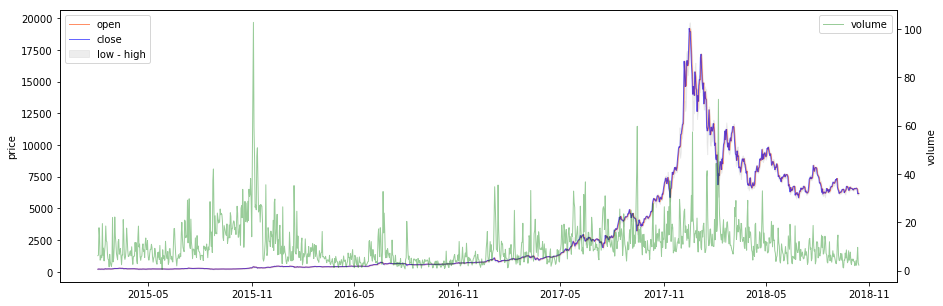

In [6]:
data24h = pd.read_csv(
    BC24H_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
print('> size:', len(data24h))
dd(data24h.dtypes)
dd(data24h.head())
dd(data24h.tail())
simple_plot(data24h, show_xlabels=False)

In [7]:
data24h['weekday'] = data24h.index.dayofweek
data24h.head()

,close,open,high,low,volume,missing,weekday
datetime,,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0,6
2015-02-02,238.0,214.8,242.0,214.8,6.42,0,0
2015-02-03,227.4,238.0,244.4,223.8,17.76,0,1
2015-02-04,227.0,227.4,231.0,220.0,14.31,0,2
2015-02-05,217.0,227.0,228.9,213.6,4.31,0,3


## Test runs

### LSTM

### `7|0.1|7|0.1`

**Conclusion:** This gives "best" results with 3 to 5 epoch... but they are simply too random. "Stable" results are only achieved at 6 to 10 epochs, but they are much worse.

data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 140333145197392
Tensor("lstm_61_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 7, 3)              60        
_________________________________________________________________
dropout_61 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_62 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_62 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
___________________________________________________________

Epoch 68/100
277/277 [==============================] - 0s 702us/step - loss: 0.0054 - val_loss: 0.0089
Epoch 69/100
277/277 [==============================] - 0s 704us/step - loss: 0.0054 - val_loss: 0.0089
Epoch 70/100
277/277 [==============================] - 0s 657us/step - loss: 0.0054 - val_loss: 0.0089
Epoch 71/100
277/277 [==============================] - 0s 616us/step - loss: 0.0054 - val_loss: 0.0089
Epoch 72/100
277/277 [==============================] - 0s 603us/step - loss: 0.0054 - val_loss: 0.0089
Epoch 73/100
277/277 [==============================] - 0s 621us/step - loss: 0.0054 - val_loss: 0.0088
Epoch 74/100
277/277 [==============================] - 0s 684us/step - loss: 0.0054 - val_loss: 0.0088
Epoch 75/100
277/277 [==============================] - 0s 651us/step - loss: 0.0054 - val_loss: 0.0088
Epoch 76/100
277/277 [==============================] - 0s 653us/step - loss: 0.0053 - val_loss: 0.0088
Epoch 77/100
277/277 [==============================] - 0s 641us

Epoch 27/100
277/277 [==============================] - 0s 705us/step - loss: 0.0053 - val_loss: 0.0087
Epoch 28/100
277/277 [==============================] - 0s 676us/step - loss: 0.0054 - val_loss: 0.0086
Epoch 29/100
277/277 [==============================] - 0s 665us/step - loss: 0.0054 - val_loss: 0.0086
Epoch 30/100
277/277 [==============================] - 0s 666us/step - loss: 0.0053 - val_loss: 0.0085
Epoch 31/100
277/277 [==============================] - 0s 705us/step - loss: 0.0052 - val_loss: 0.0085
Epoch 32/100
277/277 [==============================] - 0s 713us/step - loss: 0.0052 - val_loss: 0.0084
Epoch 33/100
277/277 [==============================] - 0s 675us/step - loss: 0.0052 - val_loss: 0.0083
Epoch 34/100
277/277 [==============================] - 0s 674us/step - loss: 0.0053 - val_loss: 0.0083
Epoch 35/100
277/277 [==============================] - 0s 678us/step - loss: 0.0052 - val_loss: 0.0082
Epoch 36/100
277/277 [==============================] - 0s 658us

> Predicting (now at 240)...
> Predicting (now at 250)...
--- 2.100s to walk and predict

--- 0.281s to plot incremental predictions

--- 0.016s to model compilation time


--- Created model id: 140333235319632
Tensor("lstm_65_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 7, 3)              60        
_________________________________________________________________
dropout_65 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_66 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 4         
Total

277/277 [==============================] - 0s 890us/step - loss: 0.0043 - val_loss: 0.0066
Epoch 67/100
277/277 [==============================] - 0s 871us/step - loss: 0.0043 - val_loss: 0.0066
Epoch 68/100
277/277 [==============================] - 0s 930us/step - loss: 0.0042 - val_loss: 0.0066
Epoch 69/100
277/277 [==============================] - 0s 883us/step - loss: 0.0042 - val_loss: 0.0066
Epoch 70/100
277/277 [==============================] - 0s 904us/step - loss: 0.0043 - val_loss: 0.0065
Epoch 71/100
277/277 [==============================] - 0s 915us/step - loss: 0.0043 - val_loss: 0.0065
Epoch 72/100
277/277 [==============================] - 0s 856us/step - loss: 0.0042 - val_loss: 0.0065
Epoch 73/100
277/277 [==============================] - 0s 902us/step - loss: 0.0042 - val_loss: 0.0064
Epoch 74/100
277/277 [==============================] - 0s 911us/step - loss: 0.0041 - val_loss: 0.0064
Epoch 75/100
277/277 [==============================] - 0s 919us/step - loss:

277/277 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0066
Epoch 26/100
277/277 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0066
Epoch 27/100
277/277 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0065
Epoch 28/100
277/277 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0065
Epoch 29/100
277/277 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0064
Epoch 30/100
277/277 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0064
Epoch 31/100
277/277 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0063
Epoch 32/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0063
Epoch 33/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0063
Epoch 34/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 

> Predicting (now at 250)...
--- 2.230s to walk and predict

--- 0.255s to plot incremental predictions



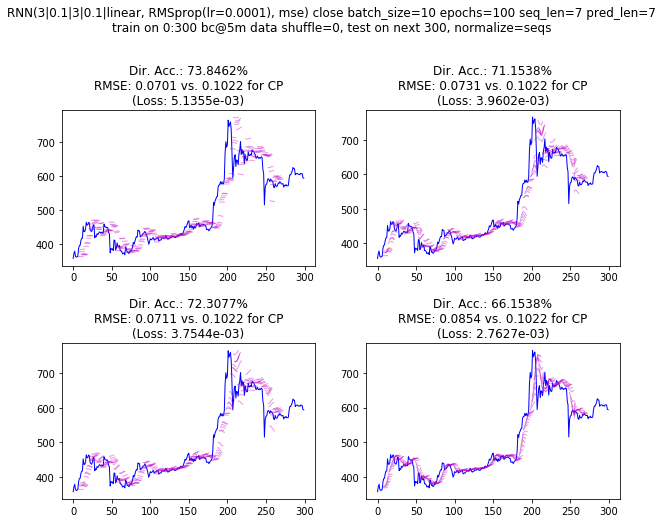

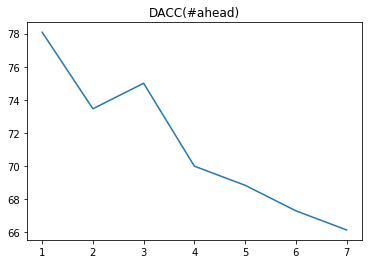

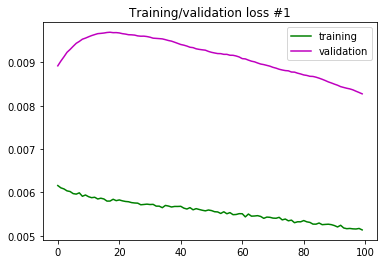

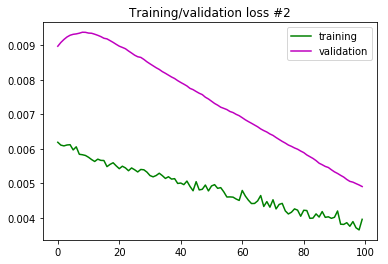

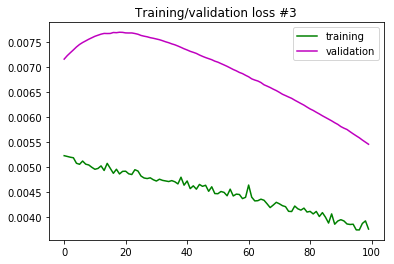

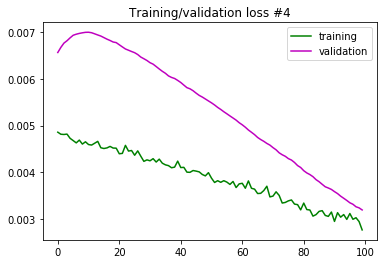

--- 176.692s to run experiment



In [29]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [3, 0.1, 3, 0.1],
            lr=0.0001,
        ),
        # training:
        epochs=100,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (600, 1)
--- 0.014s to model compilation time


--- Created model id: 140333596579984
Tensor("lstm_15_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 7, 7)              252       
_________________________________________________________________
dropout_15 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_16 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
___________________________________________________________

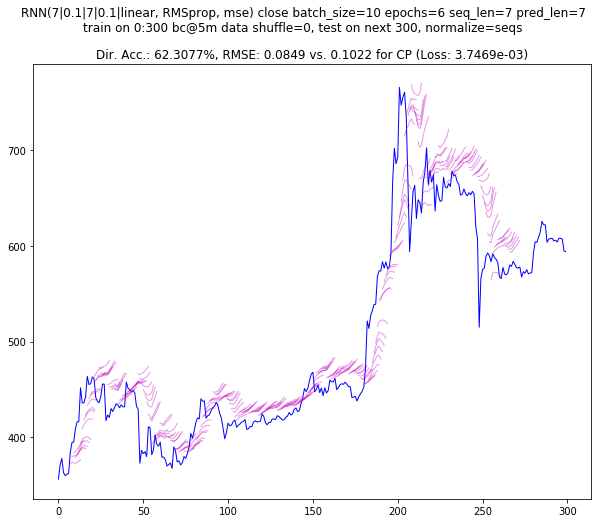

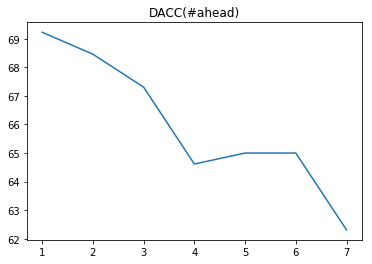

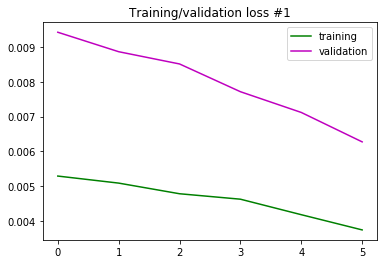

--- 5.825s to run experiment



In [15]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    for i, losses in enumerate(res['train_val_losses']):
        plt.figure()
        plt.title("Training/validation loss" +
                  (' #%d' % (i + 1)) if len(res['train_val_losses']) else '')
        plt.plot(losses['loss'], color='g', label='training')
        plt.plot(losses['val_loss'], color='m', label='validation')
        plt.legend()
        plt.show()

data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 140666865586960
Tensor("lstm_23_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 7, 7)              252       
_________________________________________________________________
dropout_23 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_24 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
___________________________________________________________

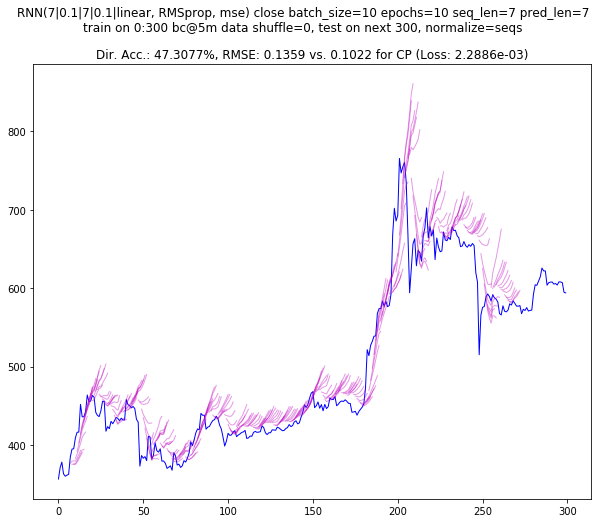

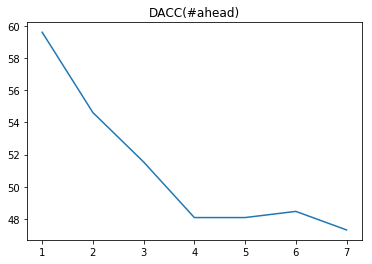

--- 9.233s to run experiment



In [20]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
        # training:
        epochs=10,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

### 3|0.1|3|0.1

**Conclusion:** Amazingly, this smaller networks gives better results than the larger ones. Best at 3 epochs.

data ~ (600, 1)
--- 0.014s to model compilation time


--- Created model id: 140333593437392
Tensor("lstm_17_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 7, 3)              60        
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_18 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
___________________________________________________________

Train on 277 samples, validate on 15 samples
Epoch 1/6
277/277 [==============================] - 3s 9ms/step - loss: 0.0055 - val_loss: 0.0088
Epoch 2/6
277/277 [==============================] - 0s 885us/step - loss: 0.0054 - val_loss: 0.0089
Epoch 3/6
277/277 [==============================] - 0s 908us/step - loss: 0.0053 - val_loss: 0.0089
Epoch 4/6
277/277 [==============================] - 0s 945us/step - loss: 0.0053 - val_loss: 0.0087
Epoch 5/6
277/277 [==============================] - 0s 790us/step - loss: 0.0051 - val_loss: 0.0085
Epoch 6/6
277/277 [==============================] - 0s 925us/step - loss: 0.0051 - val_loss: 0.0084
--- 5.534s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (no

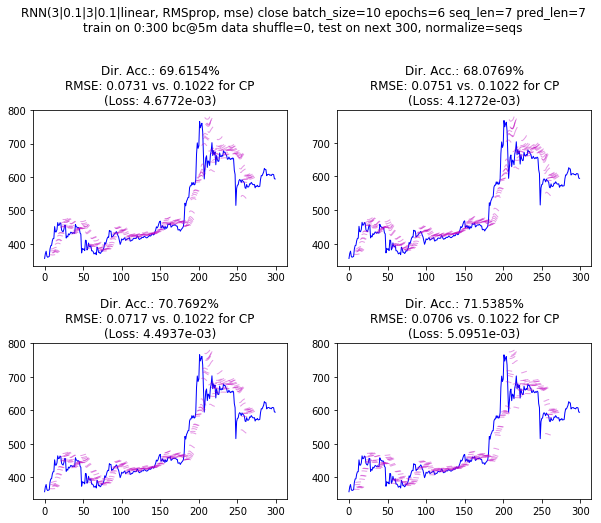

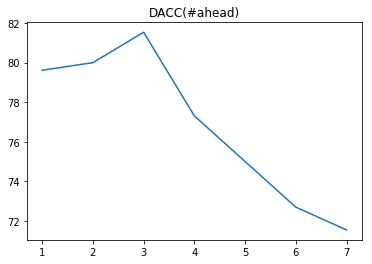

--- 29.872s to run experiment



In [16]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 1)
--- 0.016s to model compilation time


--- Created model id: 140666600637968
Tensor("lstm_51_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 7, 3)              60        
_________________________________________________________________
dropout_51 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_52 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
___________________________________________________________

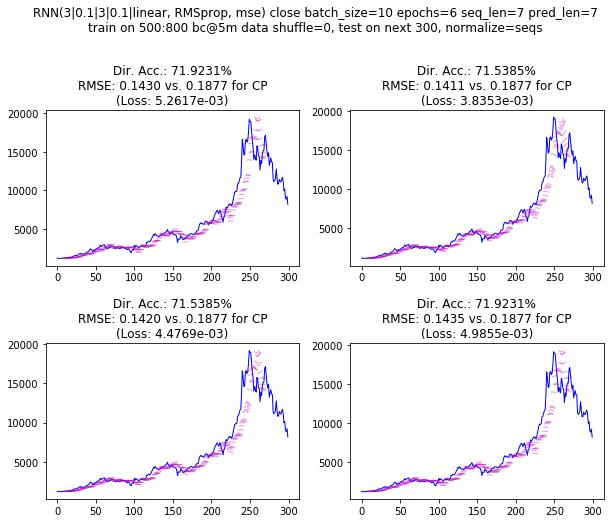

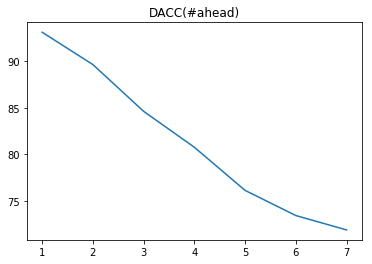

--- 44.567s to run experiment



In [28]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=500,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 1)
--- 0.055s to model compilation time


--- Created model id: 140665675744528
Tensor("lstm_155_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_155 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_155 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_156 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_156 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
__________________________________________________________

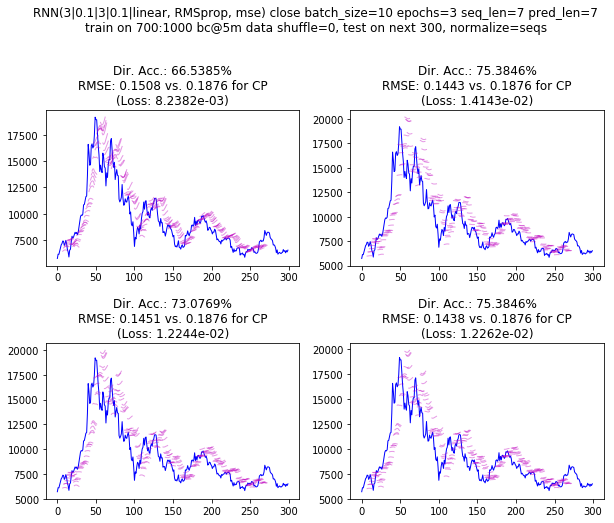

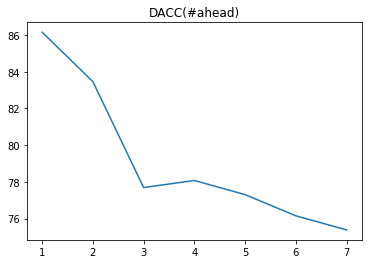

--- 188.970s to run experiment



In [41]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=700,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=3,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn_retraining(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 1)

====== 0
                x_train_seqs ~ (292, 7, 1) [...0.0101538461538]
                y_train ~ (292, 1) [...[0.09661538]]
                x_test_seqs ~ (1, 7, 1) [...0.0165544332211]
                y_test ~ (1, 1) [...[0.07940516]]
                
--- 0.015s to model compilation time


--- Created model id: 140210297286032
Tensor("lstm_1_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 3)              60        
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 3)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dropout_2 (Dropout)          (None, 3)                 0         
_

### 14|0.1|14|0.1

**Conclusion:** Amazingly, this smaller networks gives better results than the larger ones. Best at 3 epochs.

data ~ (600, 1)
--- 0.018s to model compilation time


--- Created model id: 140665388567568
Tensor("lstm_187_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_187 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
dropout_187 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_188 (LSTM)              (None, 14)                1232      
_________________________________________________________________
dropout_188 (Dropout)        (None, 14)                0         
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 15        
Total params: 1,499
Trainable params: 1,499
Non-trainable params: 0
______________________________________________________

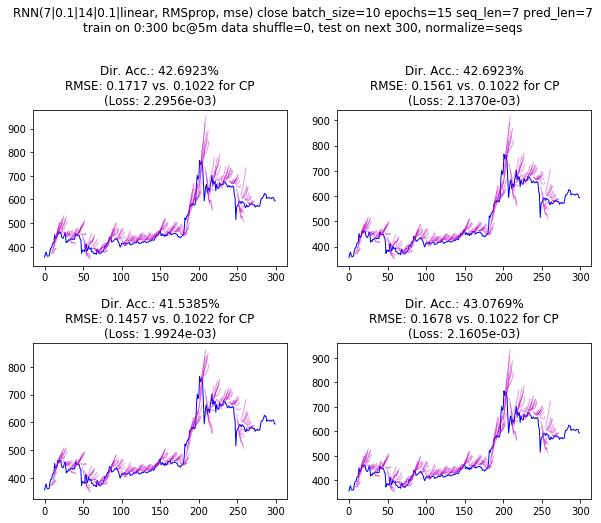

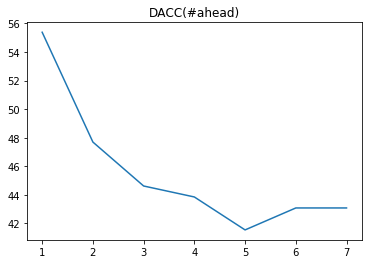

--- 293.490s to run experiment



In [45]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 14, 0.1]),
        # training:
        epochs=15,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

## Full runs

In [46]:
len(data24h) - 600

751

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [18]:
DEFAULT_PARAMS = {
    # data to extract:
    'data_df': data24h,
    'features': ['close'],
    'train_sz': 300,
    'test_sz': 300,
    # data processing:
    'normalize': 'seqs',  # 'seqs' | 'data'
    'detrend': False,
    # model and prediction arrangement:
    'seq_len': 7,
    'pred_len': 7,
    'model_maker': make_rnn_model_constructor([3, 0.1, 3, 0.1]),
    # training:
    'epochs': 3,
    'batch_size': 10,
    'shuffle': False,
    # experiment setup:
    'times': 1,
    'skip': False,
    'fix_all_rngs_to': False,
    'fix_rngs_before_each': False,
    # plotting:
    'plot': True,
    'fig_size': (10, 8),
    'fast': True,
}

CSV_FIELDS = (
    'model_description',
    'train_from',
    'train_to',
    'test_on',
    'shuffle',
    'normalize',
    'training_loss',
    'rmse',
    'rmse_cp',
    'dir_acc',
)

In [14]:
def ddump(s):
    """Print to both notebook and system stdout."""
    os.write(1, s)
    print(s)

In [15]:
def full_run(idx_from, idx_to, write_csv_header, filename, runner):
    train_sz = DEFAULT_PARAMS['train_sz']
    test_sz = DEFAULT_PARAMS['test_sz']
    
    out_file = open(filename, 'ab')
    csv_writer = csv.DictWriter(out_file, fieldnames=CSV_FIELDS)
    if write_csv_header:
        csv_writer.writeheader()
        
    with timing('full run %d - %d' % (idx_from, idx_to)):
        for i in range(idx_from, idx_to, test_sz):
            params = dict(DEFAULT_PARAMS,
                          from_i=i - train_sz)
            ddump("\n   ------ RUN %d (from %s, train on %d, test on %d)\n" % (
                i, params['from_i'], params['train_sz'], params['test_sz']))
            with timing('run segment'):
                out = runner(**params)
                csv_writer.writerow(out)
                out_file.flush()

In [62]:
dd(pd.read_csv(OUT_FILENAME))

,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...",0,300,300,False,seqs,0.004466,0.0727%,0.1022%,70.0000%
1,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...",300,600,300,False,seqs,0.004734,0.0834%,0.1147%,79.6154%
2,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...",600,900,300,False,seqs,0.007003,0.1487%,0.1967%,77.3077%


In [ ]:
full_run(300, 1051, write_csv_header=False, OUT_RETRAINED_FILENAME, run_walk_forward_validation_rnn_retraining)


   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 1)

====== 0
                x_train_seqs ~ (292, 7, 1) [...0.0101538461538]
                y_train ~ (292, 1) [...[0.09661538]]
                x_test_seqs ~ (1, 7, 1) [...0.0165544332211]
                y_test ~ (1, 1) [...[0.07940516]]
                
--- 0.015s to model compilation time


--- Created model id: 140086789219216
Tensor("lstm_17_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 7, 3)              60        
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_18

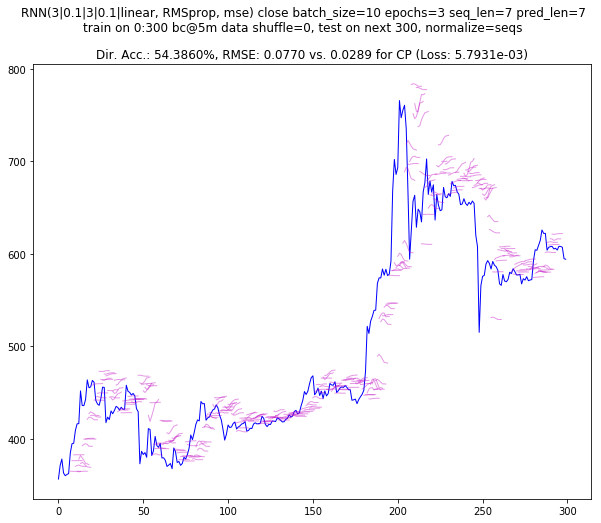

--- 11950.165s to run segment

--- 11950.166s to full run 300 - 600



In [19]:
full_run(300, 600,
    write_csv_header=False,
    filename=OUT_RETRAINED_FILENAME,
    runner=run_walk_forward_validation_rnn_retraining
)

In [ ]:
dd(pd.read_csv(OUT_RETRAINED_FILENAME))